# Settings

In [1]:
from pathlib import Path

output_directory = Path("/home/timgarrels/masterthesis/output/degree_analysis_for_non_randomized_results")
graph_edgelist = Path("/home/timgarrels/masterthesis/datasets/yeastInter_st.txt")
motif_size = 3

# Part 0: Setup

In [2]:
from os import makedirs

makedirs(output_directory, exist_ok=True)

# Part 1: Data Gathering

In [3]:
"""Load and Validate Graph"""
import networkx as nx

from motif_position_tooling.utils.motif_io import MotifGraph


nx_graph = nx.read_edgelist(
    graph_edgelist,
    create_using=nx.Graph,  # Asserts undirected graph
    data=False,  # Asserts unweighted graph
)

if len(list(nx.selfloop_edges(nx_graph))) > 0:
    raise ValueError("Graph contains Self-Loops!")  # Asserts simple graph

if min(map(int, nx_graph.nodes)) < 1:
    raise ValueError("Graph contains node ids below '1'!")  # Assert lowest node index is >= 1

motif_graph = MotifGraph(graph_edgelist.parent, graph_edgelist.name, output_directory)

In [4]:
"""Motif Detection"""
from motif_position_tooling.utils.gtrieScannerUtils import gtrieScanner
from motif_position_tooling.config import GTRIESCANNER_EXECUTABLE

try:
    # This can take a long time
    gtrieScanner(
        graph_edgelist=motif_graph.get_graph_path(),
        gtrieScanner_executable=GTRIESCANNER_EXECUTABLE,
        directed=False,
        motif_size=motif_size,
        output_directory=motif_graph.get_motif_directory(),
    )
except FileExistsError:
    # Gtrie already ran, use file from previous run
    pass

In [5]:
"""Positional Metrics"""
import json

from motif_position_tooling.utils.positional_metrics import calculate_metrics


if motif_graph.get_motif_metric_json(motif_size).is_file():
    with open(motif_graph.get_motif_metric_json(motif_size), "r") as f:
        data = json.load(f)
    # JSON stores keys as str, change them back to int
    data["motif_data"] = {int(k): v for k,v in data["motif_data"].items()}
else:
    # This can take an even longer time
    data = calculate_metrics(motif_graph, motif_size)
    with open(motif_graph.get_motif_metric_json(motif_size), "w") as f:
        json.dump(data, f)
    

# Part 2 : Graphlet Analyses

In [7]:
"""Load Motifs and Positional Metrics"""
import pandas as pd

from motif_position_tooling.utils.motif_io import load_motif_zip


motif_pos_lookup = load_motif_zip(motif_graph.get_motif_pos_zip(motif_size))

motif_data = []
for i, (motif_id, motif_nodes) in enumerate(motif_pos_lookup):
    degree = data["motif_data"][i][1]["motif_degree"]

    motif_data.append({
        "index": i,
        "motif_id": motif_id,
        "motif_nodes": motif_nodes,
        "degree": degree,
    })
    
df = pd.DataFrame(motif_data).set_index("index")
df

,motif_id,motif_nodes,degree
index,,,
0,001 001 110,"[1, 688, 182]",12
1,001 001 110,"[1, 688, 687]",32
2,001 001 110,"[1, 688, 686]",16
3,001 001 110,"[1, 688, 685]",19
4,001 001 110,"[1, 688, 684]",38
...,...,...,...
110898,001 001 110,"[625, 679, 634]",38
110899,001 001 110,"[625, 659, 634]",38
110900,001 001 110,"[662, 673, 677]",9


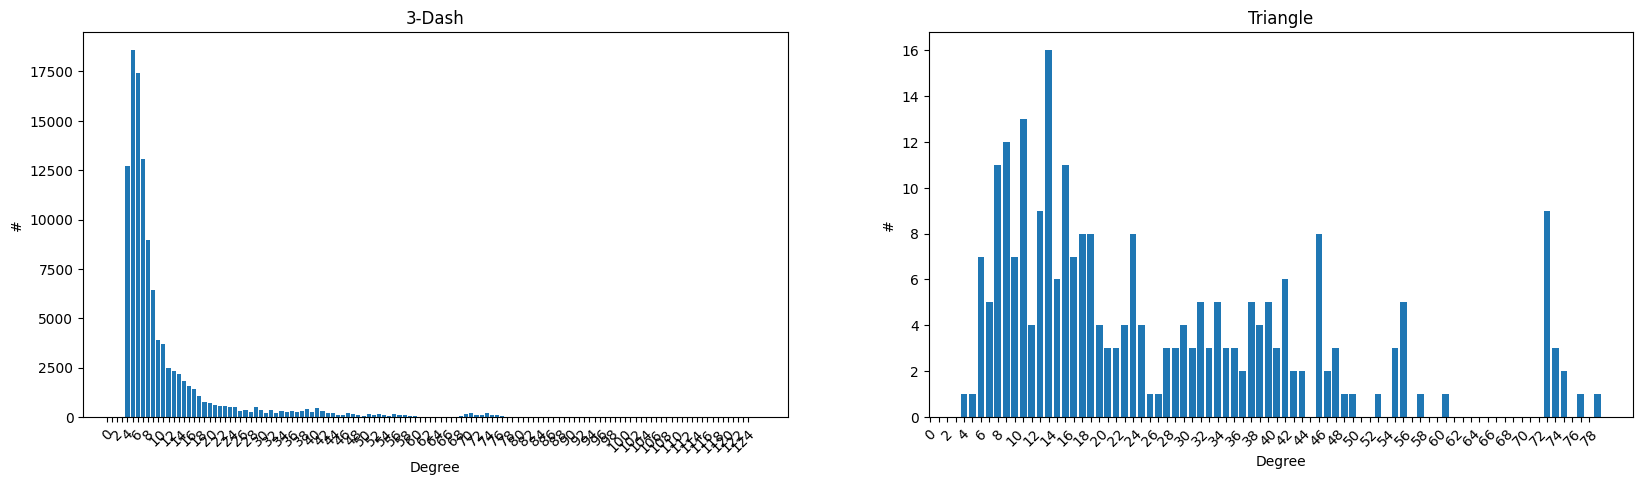

In [8]:
"""Plot Degree Distribution of each motif_id"""
import matplotlib.pyplot as plt
from collections import defaultdict

from motif_position_tooling.utils.motif_names import MOTIF_NAME_LOOKUP


def to_count(l):
    counts = defaultdict(int)
    for e in l:
        counts[e] += 1
    return counts        
        

degrees_per_motif_id = df.groupby("motif_id").agg(list)["degree"]
motif_ids = degrees_per_motif_id.index

fig, axes = plt.subplots(1, len(motif_ids), figsize=(20, 5))

for i, m_id in enumerate(motif_ids):
    freq = to_count(degrees_per_motif_id[m_id])
    axes[i].bar(freq.keys(), freq.values())
    axes[i].set_title(MOTIF_NAME_LOOKUP[m_id])
    axes[i].set_xticks(range(max(freq.keys())))
    axes[i].set_xticklabels([i if not i % 2 else "" for i in range(max(freq.keys()))], rotation=45)
    
    axes[i].set_xlabel("Degree")
    axes[i].set_ylabel("#")
    

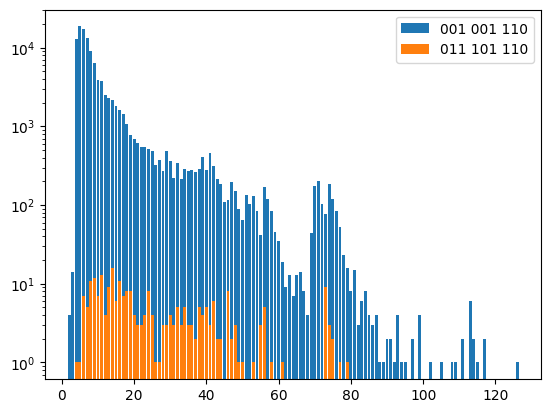

In [9]:
fig, ax = plt.subplots(1,1)

for i, m_id in enumerate(motif_ids):
    freq = to_count(degrees_per_motif_id[m_id])
    ax.bar(freq.keys(), freq.values(), label=m_id)
ax.set_yscale("log")
ax.legend()

It can be seen that the degree of the 3-Dash occurences is vastly higher than the degree of the triangle occurrences. As any triangle can be turned to a 3-Dash by removing one edge, the histogram of "Triangle" is contained in the "3-Dash" histogram.

Despite this fact, this histogram suggests that the most connected graphlet is the 3-Dash, especially the most connected parts of the graph are 3-Dash occurrences.

This histogram already suggests that a few trianlge occurences are significantly more connected than other triangle occurences.

Local Outlier Factor
PCA
Isolation Forest
